In [285]:
import os
import json
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_rows', 10)
mvc_properties = ["ICNB", "GCNB", "LCMB", "GCPB", "LCNB"]
property_dict = {1: "ICNB", 2: "GCNB", 3: "LCMB", 4: "GCPB", 5: "LCNB"}
iv_list = [3, 4]
sl_list = [1, 2, 3, 5]
k_relax_list = [2, 3, 5]

mvc_str = "mvc_properties"
read_str = "read_behavior"
write_str = "write_behavior"
iv_str = "invisibility"
sl_str = "staleness"
tt_str = "total_time"
iv_sl_str = "iv_sl"
run_str = "RUN"
interval_str = "refresh_interval"
vp_range_str = "viewport_range"
vp_shift_str = "shift_step"
explore_str = "explore_range"
agg_value = "mean"
k_str = "k_relaxed"
one_k=1000
log_time_str = "log_time"


notebook_home= os.path.abspath('')
experiment_home=notebook_home + "/../experiment_results"

# parse a stat report
def parse_stat_report(file_path: str):
    with open(file_path) as json_file:
        return json.load(json_file)
    
def parse_int(filename: str) -> int:
    start = re.search(r"\d", filename).start()
    return int(filename[start:])

def add_error_bound(df):
    df = df.reset_index()
    df["lower"] = df[agg_value] - df["min"]
    df["upper"] = df["max"] - df[agg_value]
    df = df.drop(["max", "min"], axis =1)
    return df

def massage_data(df, metric_type, k_relaxed = False):
    #new_df = df[metric_type]/df[tt_str]
    new_df = df[metric_type]/one_k
    new_df = add_error_bound(new_df)
    if k_relaxed:
        new_df = new_df[new_df[mvc_str].isin(k_relax_list)]
    elif metric_type == iv_str:
        new_df = new_df[new_df[mvc_str].isin(iv_list)]
    elif metric_type == sl_str:
        new_df = new_df[new_df[mvc_str].isin(sl_list)]
    new_df[mvc_str] = new_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
    return new_df
    

def read_one_file(df, root, file, dim_one, dim_two):
    result = parse_stat_report(os.path.join(root, file))
    run = parse_int(os.path.basename(root))
    dim_one_result = result[dim_one]
    dim_two_result = int(result[dim_two])
    iv = float(result[iv_str])
    sl = float(result[sl_str])
    iv_sl = iv + sl
    vp_range = float(result[vp_range_str])
    tt = float(result[tt_str])/vp_range
    df.loc[len(df.index)] = [dim_one_result, dim_two_result, run, iv, sl, iv_sl, tt]

def read_raw_data(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for root, dirs, files in os.walk(result_home):
        for file in files:
            if file == "stat.out":
                read_one_file(df, root, file, dim_one, dim_two)
    return df

def read_raw_data_by_dir_name(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    read_one_file(df, root, file, dim_one, dim_two)
    return df

In [286]:
#Color configuration
import matplotlib.cm as cm
from matplotlib import rcParams
GRAPH_COLOR = cm.YlGnBu
mvc_color_dict = {"ICNB": GRAPH_COLOR(60),
              "GCNB": GRAPH_COLOR(90),
              "LCMB": GRAPH_COLOR(140),
              "GCPB": GRAPH_COLOR(190),
              "LCNB": GRAPH_COLOR(240)}
def to_color(mvc):
    return color_dict[mvc]

# font
rcParams['font.family'] = 'Serif'
legend_size = 15
x_label_size = 20
y_label_size = 20
x_tick_size = 20
y_tick_size = 20

# Fig size
fig_width=8
fig_height=5

config_name_dict = {
    explore_str: "Explore Range",
    vp_range_str: "Viewport Size",
    vp_shift_str: "Shift Step",
    iv_str: "Invisibility (s)",
    sl_str: "Staleness (s)",
    k_str: "Number of IVs Relaxed"
}

# mapping to the names we want to use in the plots
mvc_name_dict = {"ICNB": "IN",
             "GCNB": "GN",
             "LCMB": "LM",
             "GCPB": "GP",
             "LCNB": "LN"}
k_mvc_name_dict = {"GCNB": "k-GN",
                   "LCMB": "k-LM",
                   "LCNB": "k-LN"}

read_name_dict = {"regular_change": "Regular Move",
                  "see_change": "Wait and Move",
                  "random_regular_change": "Random Move"}

mvc_marker_dict={"ICNB": "o",
             "GCNB": "v",
             "LCMB": "^",
             "GCPB": "s",
             "LCNB": "*"}
mvc_marker_size=10

In [287]:
import matplotlib.pyplot as plt

def draw_group_bar_charts(df,
                          group_label_header,
                          bar_label_header,
                          y_axis_header,
                          y_label,
                          fig_size,
                          bar_width,
                          y_tick_max,
                          y_tick_num,
                          legend_size,
                          x_tick_size,
                          y_tick_size,
                          y_label_size,
                          group_label_dict,
                          bar_label_dict,
                          bar_label_color_dict,
                          pdf_path,
                          ncol=4):
    group_labels = [group_label_dict[old_label] for old_label in df[group_label_header].unique()]
    bar_labels = df[bar_label_header].unique()

    x_ticks = np.arange(len(group_labels))  # the group label locations
    num_bars = len(bar_labels)

    fig, ax = plt.subplots(figsize=fig_size)
    for idx, bar_label in enumerate(bar_labels):
        df_subgroup = df[df[bar_label_header] == bar_label]
        err = df_subgroup[["lower", "upper"]].values.transpose()
        rect = ax.bar(x_ticks - ((num_bars - 1) * bar_width)/2 + idx * bar_width,
                      df_subgroup[y_axis_header].values,
                      bar_width, yerr=err, label=bar_label_dict[bar_label],
                      color=bar_label_color_dict[bar_label], ecolor="red")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label, fontsize=y_label_size)
    y_ticks = np.arange(0, y_tick_max+0.1, step=y_tick_max/y_tick_num).astype(int)
    ax.set_yticks(y_ticks, y_ticks, fontsize=y_tick_size)
    ax.set_xticks(x_ticks, group_labels, fontsize=x_tick_size)
    ax.legend(fontsize=legend_size, ncol=ncol)
    fig.tight_layout()
    
    plt.savefig(pdf_path)
    plt.show()

def plot_line_chart(df,
                    x_axis_header,
                    y_axis_header,
                    line_label_header,
                    x_label,
                    y_label,
                    fig_size,
                    y_tick_max,
                    y_tick_num,
                    x_tick_min,
                    x_tick_max,
                    x_tick_num,
                    legend_size,
                    tick_size,
                    label_size,
                    line_label_dict,
                    line_label_color_dict,
                    marker_dict,
                    marker_size,
                    pdf_path):
    line_labels = df[line_label_header].unique()
    fig, ax = plt.subplots(figsize=fig_size)
    for line_label in line_labels:
        df_subgroup = df[df[line_label_header] == line_label]
        #err = df_subgroup[["lower", "upper"]].values.transpose()
        #line = ax.errorbar(df_subgroup[x_axis_header].values, df_subgroup[y_axis_header].values, yerr=err, label=line_label)
        line = ax.plot(df_subgroup[x_axis_header].values,
                       df_subgroup[y_axis_header].values,
                       label=line_label_dict[line_label],
                       color=line_label_color_dict[line_label],
                       marker=marker_dict[line_label],
                       markersize=marker_size)
    
    ax.set_ylabel(y_label, fontsize=label_size)
    ax.set_xlabel(x_label, fontsize=label_size)
    y_ticks = np.arange(0, y_tick_max+0.1, step=y_tick_max/y_tick_num).astype(int)
    x_ticks = np.arange(x_tick_min, x_tick_max+0.1, step=(x_tick_max - x_tick_min)/x_tick_num).astype(int)
    ax.set_yticks(y_ticks, y_ticks, fontsize=tick_size)
    ax.set_xticks(x_ticks, x_ticks, fontsize=tick_size)
    ax.legend(fontsize=legend_size, ncol=4)
    fig.tight_layout()
    
    plt.savefig(pdf_path)
    plt.show()

## Plots for different read behaviors

In [288]:
read_behavior_results =  os.path.join(experiment_home, read_str)
df = read_raw_data_by_dir_name(read_behavior_results, read_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([read_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,read_behavior,mvc_properties,mean,lower,upper
2,random_regular_change,LCMB,2.800000,1.200000,1.900000
3,random_regular_change,GCPB,43.900000,8.000000,8.900000
7,regular_change,LCMB,15.766667,0.766667,0.933333
8,regular_change,GCPB,56.566667,0.966667,0.733333
12,see_change,LCMB,43.233333,0.633333,0.666667
13,see_change,GCPB,57.933333,0.133333,0.266667


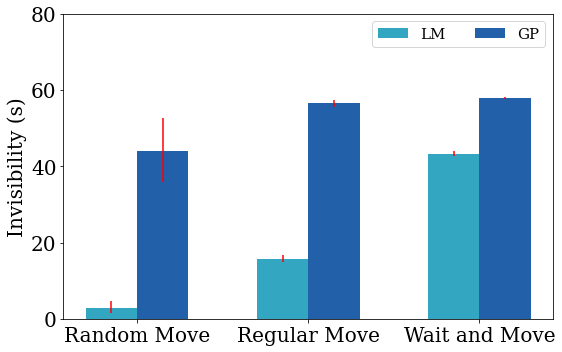

In [289]:
read_iv_fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{read_str}_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=read_str,
                      bar_label_header=mvc_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=read_iv_fig_size,
                      y_tick_max=80,
                      y_tick_num=4,
                      bar_width=0.3,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=read_name_dict,
                      bar_label_dict=mvc_name_dict,
                      bar_label_color_dict=mvc_color_dict,
                      pdf_path=pdf_path)

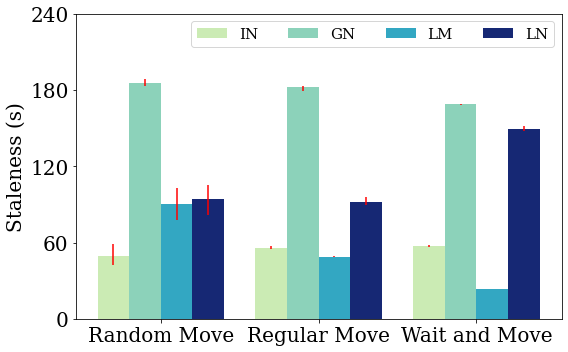

In [290]:
sl_df = massage_data(agg_df, sl_str)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{read_str}_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=read_str,
                      bar_label_header=mvc_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=fig_size,
                      y_tick_max=240,
                      y_tick_num=4,
                      bar_width=0.2,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=read_name_dict,
                      bar_label_dict=mvc_name_dict,
                      bar_label_color_dict=mvc_color_dict,
                      pdf_path=pdf_path)

## Plots for different explore ranges

In [291]:
regular_change_results =  os.path.join(experiment_home, explore_str)
df = read_raw_data_by_dir_name(regular_change_results, explore_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([explore_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,explore_range,mvc_properties,mean,lower,upper
2,4.0,LCMB,0.000000,0.000000,0.000000
3,4.0,GCPB,12.625000,4.825000,1.775000
7,10.0,LCMB,2.666667,0.066667,0.033333
8,10.0,GCPB,19.366667,0.266667,0.233333
12,16.0,LCMB,2.466667,0.066667,0.033333
13,16.0,GCPB,33.266667,0.166667,0.233333
17,22.0,LCMB,15.766667,0.766667,0.933333
18,22.0,GCPB,56.566667,0.966667,0.733333


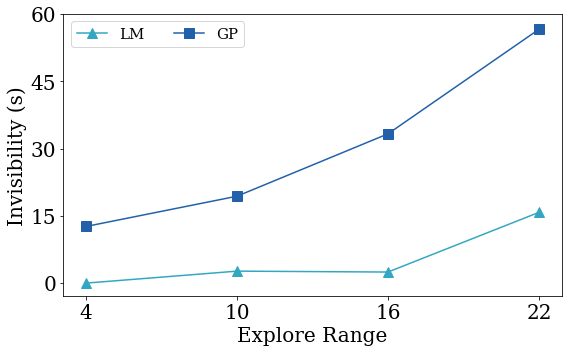

In [292]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_iv.pdf'
plot_line_chart(df=iv_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=60,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=legend_size,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

In [293]:
sl_df = massage_data(agg_df, sl_str)
sl_df

,explore_range,mvc_properties,mean,lower,upper
0,4.0,ICNB,12.575000,4.675000,1.925000
1,4.0,GCNB,152.500000,2.900000,1.900000
2,4.0,LCMB,21.400000,6.200000,2.200000
4,4.0,LCNB,23.333333,0.133333,0.266667
5,10.0,ICNB,19.366667,0.066667,0.033333
...,...,...,...,...,...
14,16.0,LCNB,52.000000,0.000000,0.000000
15,22.0,ICNB,55.700000,0.900000,1.400000
16,22.0,GCNB,182.266667,2.666667,1.333333
17,22.0,LCMB,48.933333,0.533333,0.666667


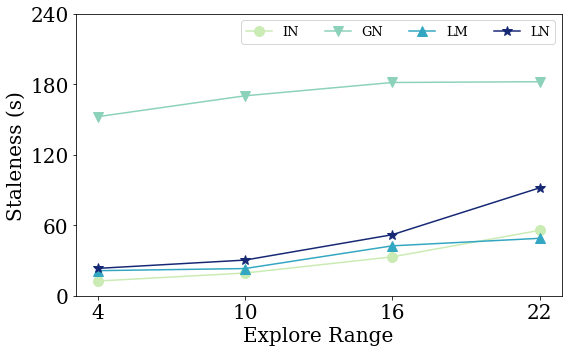

In [294]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=240,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

## Plots for different viewport size

In [295]:
viewport_range =  os.path.join(experiment_home, "dash_config", vp_range_str)
df = read_raw_data(viewport_range, vp_range_str, mvc_str)
df = df.sort_values([vp_range_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([vp_range_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
agg_df

invisibility                     staleness  \
                                      mean       min       max      mean   
viewport_range mvc_properties                                              
4.0            1.0                     0.0       0.0       0.0   56790.0   
               2.0                     0.0       0.0       0.0  180960.0   
               3.0                 12860.0    3200.0   36100.0   58080.0   
               4.0                 56640.0   54700.0   58500.0       0.0   
               5.0                     0.0       0.0       0.0   86960.0   
...                                    ...       ...       ...       ...   
22.0           1.0                     0.0       0.0       0.0  275400.0   
               2.0                     0.0       0.0       0.0  823020.0   
               3.0                     0.0       0.0       0.0  826760.0   
               4.0                276600.0  271000.0  284400.0       0.0   
               5.0                     0.0       0.0       0.0  825440.0   

                                                      iv_sl            \
                                    min       max      mean       min   
viewport_range mvc_properties                                           
4.0            1.0              55100.0   58600.0   56790.0   55100.0   
               2.0             176400.0  184400.0  180960.0  176400.0   
               3.0              26400.0   80400.0   70940.0   62500.0   
               4.0                  0.0       0.0   56640.0   54700.0   
               5.0              82400.0   92400.0   86960.0   82400.0   
...                                 ...       ...       ...       ...   
22.0           1.0             266800.0  279600.0  275400.0  266800.0   
               2.0             805200.0  844800.0  823020.0  805200.0   
               3.0             807400.0  844800.0  826760.0  807400.0   
               4.0                  0.0       0.0  276600.0  271000.0   
               5.0             816200.0  844800.0  825440.0  816200.0   

                                        total_time                    
                                    max       mean      min      max  
viewport_range mvc_properties                                         
4.0            1.0              58600.0    46720.0  46500.0  47000.0  
               2.0             184400.0    46710.0  46500.0  46900.0  
               3.0              84800.0    46730.0  46400.0  46900.0  
               4.0              58500.0    46480.0  45700.0  46900.0  
               5.0              92400.0    46370.0  45300.0  46900.0  
...                                 ...        ...      ...      ...  
22.0           1.0             279600.0    46380.0  45200.0  46700.0  
               2.0             844800.0    46480.0  44800.0  46900.0  
               3.0             844800.0    46550.0  46400.0  46700.0  
               4.0             284400.0    46490.0  45800.0  46800.0  
               5.0             844800.0    46580.0  46200.0  46900.0  

[20 rows x 12 columns]

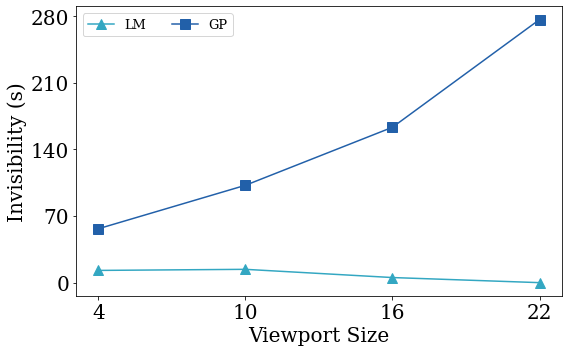

In [296]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{vp_range_str}_iv.pdf'
plot_line_chart(df=iv_df,
                x_axis_header=vp_range_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[vp_range_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=280,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

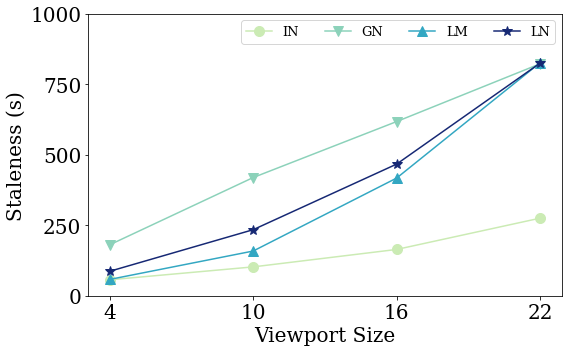

In [297]:
sl_df = massage_data(agg_df, sl_str)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{vp_range_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=vp_range_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[vp_range_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=1000,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

## Plots for different k-relaxed

In [298]:
k_path =  os.path.join(experiment_home, k_str)
df = read_raw_data(k_path, k_str, mvc_str)
df = df.sort_values([k_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([k_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str, True)
iv_df

,k_relaxed,mvc_properties,mean,lower,upper
0,0.0,GCNB,0.000000,0.000000,0.000000
1,0.0,LCMB,16.566667,0.466667,0.333333
2,0.0,LCNB,0.000000,0.000000,0.000000
3,2.0,GCNB,0.800000,0.000000,0.000000
4,2.0,LCMB,22.566667,0.166667,0.233333
...,...,...,...,...,...
13,16.0,LCMB,57.400000,0.600000,0.700000
14,16.0,LCNB,56.566667,1.466667,1.433333
15,22.0,GCNB,57.366667,0.066667,0.133333
16,22.0,LCMB,56.800000,0.500000,0.400000


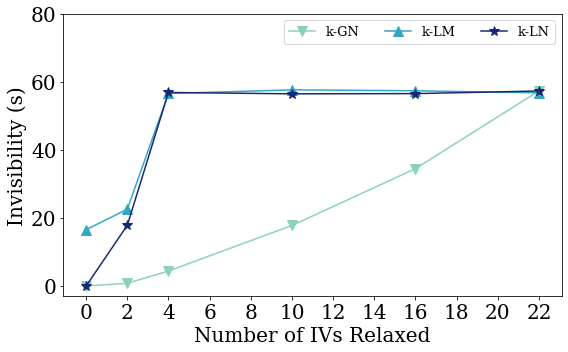

In [299]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{k_str}_iv.pdf'
plot_line_chart(df=iv_df,
                x_axis_header=k_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[k_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=22,
                x_tick_num=11,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

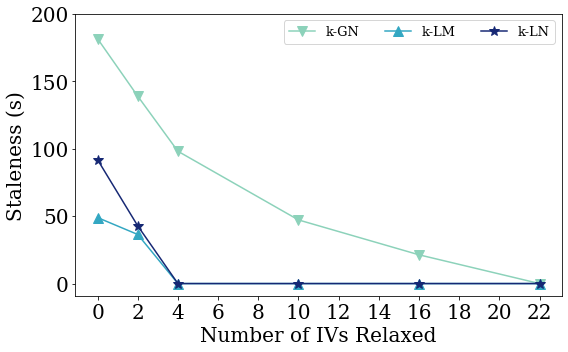

In [300]:
sl_df = massage_data(agg_df, sl_str, True)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{k_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=k_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[k_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=200,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=22,
                x_tick_num=11,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

In [301]:
iv_sl_df = agg_df[[iv_str, sl_str]].iloc[:, [0, 3]]/one_k
iv_sl_df.columns = iv_sl_df.columns.get_level_values(0)
iv_sl_df = iv_sl_df.reset_index()
iv_sl_df[mvc_str] = iv_sl_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
#iv_sl_df = iv_sl_df[(iv_sl_df['mvc_properties'] == 'LCMB') | (iv_sl_df['mvc_properties'] == 'GCNB')]

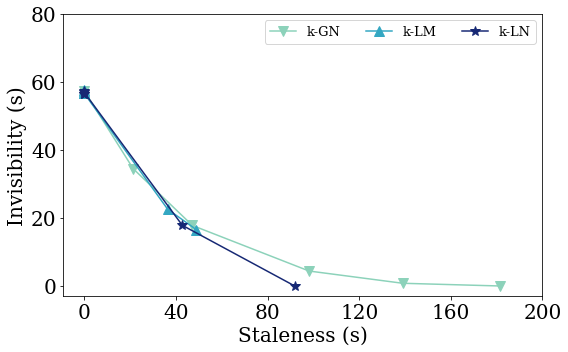

In [302]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{k_str}_iv_sl.pdf'
plot_line_chart(df=iv_sl_df,
                x_axis_header=sl_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=config_name_dict[sl_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=200,
                x_tick_num=5,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

## Plots for Invisibility and Staleness Trace

In [303]:
def parse_iv_sl_report(df, file_path: str):
    with open(file_path) as fp:
        json_objects = fp.read()
        json_objects = json_objects.replace('}{', '}\n\n{')
        json_objects = json_objects.split('\n\n')
        for (i, json_obj) in enumerate(json_objects):
            if i == 0:
                meta_info = json.loads(json_obj)
                mvc = int(meta_info[mvc_str])
            elif i > 1:
                one_log = json.loads(json_obj)
                iv = float(one_log["iv"])
                sl = float(one_log["sl"])
                df.loc[len(df.index)] = [property_dict[mvc], i - 2, iv, sl]
                
def load_iv_sl_data(result_home):
    df = pd.DataFrame(columns=[mvc_str, log_time_str, iv_str, sl_str])
    for root, dirs, files in os.walk(result_home):
        for file in files:
            if file == "iv_sl.log":
                parse_iv_sl_report(df, os.path.join(root, file))
    return df

In [304]:
df = load_iv_sl_data(os.path.join(experiment_home, "trace"))
df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,0,4.0,0.0
1,GCPB,1,4.0,0.0
2,GCPB,2,4.0,0.0
3,GCPB,3,4.0,0.0
4,GCPB,4,4.0,0.0
...,...,...,...,...
1326,LCNB,262,0.0,0.0
1327,LCNB,263,0.0,0.0
1328,LCNB,264,0.0,0.0
1329,LCNB,265,0.0,0.0


In [305]:
n = 10
round_up_second=10
new_df = pd.DataFrame(columns=[mvc_str, log_time_str, iv_str, sl_str])
for mvc_value in df[mvc_str].unique():
    one_df = df[df[mvc_str] == mvc_value]
    one_df = one_df.set_index([mvc_str, log_time_str])
    one_df = one_df.rolling(n).mean()[(n-1)::n]
    one_df = one_df.reset_index()
    new_df = pd.concat([new_df, one_df])
new_df[log_time_str] = new_df[log_time_str].div(round_up_second)
new_df[log_time_str] = new_df[log_time_str].apply(lambda x: round(x))
new_df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,1,3.8,0.0
1,GCPB,2,4.0,0.0
2,GCPB,3,4.0,0.0
3,GCPB,4,3.4,0.0
4,GCPB,5,3.4,0.0
...,...,...,...,...
21,LCNB,22,0.0,4.0
22,LCNB,23,0.0,1.6
23,LCNB,24,0.0,2.8
24,LCNB,25,0.0,0.8


In [306]:
iv_df = new_df[(new_df[mvc_str] == 'GCPB') | (new_df[mvc_str] == 'LCMB')]
iv_df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,1,3.8,0.0
1,GCPB,2,4.0,0.0
2,GCPB,3,4.0,0.0
3,GCPB,4,3.4,0.0
4,GCPB,5,3.4,0.0
...,...,...,...,...
21,LCMB,22,1.0,0.0
22,LCMB,23,0.4,0.0
23,LCMB,24,0.7,0.0
24,LCMB,25,0.2,0.0


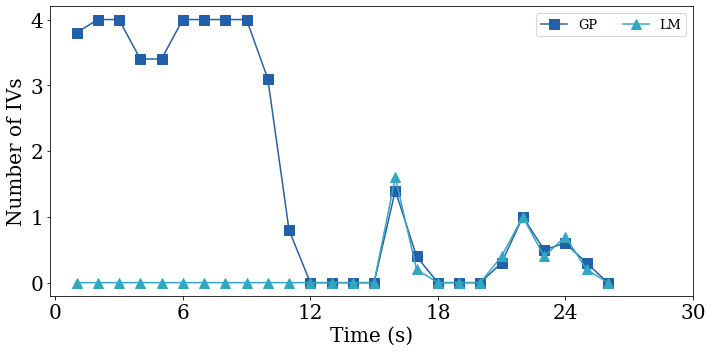

In [307]:
trace_fig_size = (fig_width+2, fig_height)
pdf_path = f'{notebook_home}/trace_iv.pdf'
log_time_label = "Time (s)"
iv_label = "Number of IVs"
sl_label = "Number of Stale Views"
plot_line_chart(df=iv_df,
                x_axis_header=log_time_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=log_time_label,
                y_label=iv_label,
                fig_size=trace_fig_size,
                y_tick_max=4,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=30,
                x_tick_num=5,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

In [308]:
sl_df = new_df[(new_df[mvc_str] != 'GCPB')]
sl_df

,mvc_properties,log_time,invisibility,staleness
0,ICNB,1,0.0,3.8
1,ICNB,2,0.0,4.0
2,ICNB,3,0.0,4.0
3,ICNB,4,0.0,3.4
4,ICNB,5,0.0,3.4
...,...,...,...,...
21,LCNB,22,0.0,4.0
22,LCNB,23,0.0,1.6
23,LCNB,24,0.0,2.8
24,LCNB,25,0.0,0.8


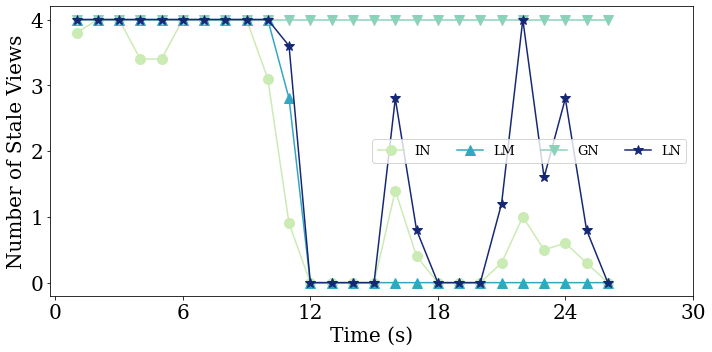

In [309]:
pdf_path = f'{notebook_home}/trace_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=log_time_str,
                y_axis_header=sl_str,
                line_label_header=mvc_str,
                x_label=log_time_label,
                y_label=sl_label,
                fig_size=trace_fig_size,
                y_tick_max=4,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=30,
                x_tick_num=5,
                legend_size=legend_size-2,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=mvc_marker_size,
                pdf_path=pdf_path)

## Plots for scheduler optimizations

In [310]:
opt_name_dict = {"optimization_false_false": "NoOpt", 
                 "optimization_true_false": "ExecTimeOpt",
                 "optimization_false_true": "ViewportOpt",
                 "optimization_true_true": "BothOpt"}
opt_color_dict = {"optimization_false_false": GRAPH_COLOR(60), 
                 "optimization_true_false": GRAPH_COLOR(120),
                 "optimization_false_true": GRAPH_COLOR(180),
                 "optimization_true_true": GRAPH_COLOR(240)}

opt_viewport_str = "opt_viewport"
opt_exec_time_str = "opt_exec_time"
opt_str = "optimization"
opt_fig_size = (fig_width, fig_height)
opt_bar_width = 0.2
opt_iv_max = 80
opt_sl_max = 160
num_y_ticks = 4
ncol = 2
def read_raw_data_for_optimizations(result_home):
    df = pd.DataFrame(columns=[mvc_str, opt_str, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    result = parse_stat_report(os.path.join(root, file))
                    run = parse_int(os.path.basename(root))
                    mvc_result = result[mvc_str]
                    opt_result = f'{opt_str}_{result[opt_exec_time_str]}_{result[opt_viewport_str]}'
                    iv = float(result[iv_str])
                    sl = float(result[sl_str])
                    iv_sl = iv + sl
                    vp_range = float(result[vp_range_str])
                    tt = float(result[tt_str])/vp_range
                    df.loc[len(df.index)] = [mvc_result, opt_result.lower(), run, iv, sl, iv_sl, tt]
    return df

In [311]:
result_home = os.path.join(experiment_home, opt_str, "random_regular_change")
raw_df = read_raw_data_for_optimizations(result_home)
raw_df

,mvc_properties,optimization,RUN,invisibility,staleness,iv_sl,total_time
0,4,optimization_false_true,2,44000.0,0.0,44000.0,26900.0
1,4,optimization_false_true,3,65200.0,0.0,65200.0,27200.0
2,4,optimization_false_true,1,48300.0,0.0,48300.0,27000.0
3,1,optimization_false_true,2,0.0,44600.0,44600.0,26600.0
4,1,optimization_false_true,3,0.0,43700.0,43700.0,27200.0
...,...,...,...,...,...,...,...
55,2,optimization_true_false,3,0.0,107600.0,107600.0,27000.0
56,2,optimization_true_false,1,0.0,107200.0,107200.0,26900.0
57,5,optimization_true_false,2,0.0,90400.0,90400.0,27200.0
58,5,optimization_true_false,3,0.0,62000.0,62000.0,27200.0


In [312]:
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,mvc_properties,optimization,mean,lower,upper
8,LCMB,optimization_false_false,1.433333,1.433333,2.866667
9,LCMB,optimization_false_true,4.733333,4.733333,4.266667
10,LCMB,optimization_true_false,2.700000,1.800000,3.600000
11,LCMB,optimization_true_true,1.733333,1.733333,1.666667
12,GCPB,optimization_false_false,53.566667,8.966667,4.633333
13,GCPB,optimization_false_true,52.500000,8.500000,12.700000
14,GCPB,optimization_true_false,33.666667,2.466667,4.233333
15,GCPB,optimization_true_true,38.100000,1.800000,2.800000


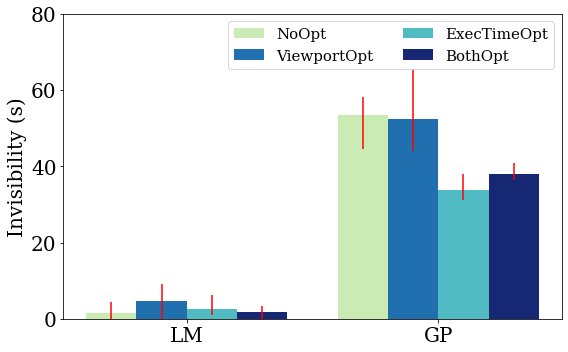

In [313]:
pdf_path = f'{notebook_home}/{opt_str}_random_regular_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

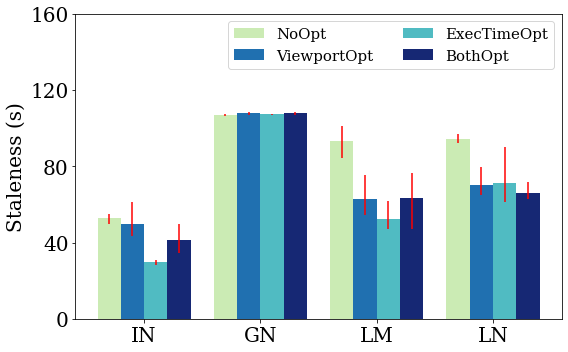

In [314]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_random_regular_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

In [315]:
result_home = os.path.join(experiment_home, opt_str, "regular_change")
raw_df = read_raw_data_for_optimizations(result_home)
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
agg_df

invisibility                    \
                                                 mean      min      max   
mvc_properties optimization                                               
1              optimization_false_false      0.000000      0.0      0.0   
               optimization_false_true       0.000000      0.0      0.0   
               optimization_true_false       0.000000      0.0      0.0   
               optimization_true_true        0.000000      0.0      0.0   
2              optimization_false_false      0.000000      0.0      0.0   
...                                               ...      ...      ...   
4              optimization_true_true    43266.666667  43200.0  43300.0   
5              optimization_false_false      0.000000      0.0      0.0   
               optimization_false_true       0.000000      0.0      0.0   
               optimization_true_false       0.000000      0.0      0.0   
               optimization_true_true        0.000000      0.0      0.0   

                                             staleness                      \
                                                  mean       min       max   
mvc_properties optimization                                                  
1              optimization_false_false   55866.666667   51700.0   58000.0   
               optimization_false_true    47766.666667   46700.0   49900.0   
               optimization_true_false    38733.333333   38100.0   39300.0   
               optimization_true_true     43433.333333   43200.0   43800.0   
2              optimization_false_false  107866.666667  107600.0  108000.0   
...                                                ...       ...       ...   
4              optimization_true_true         0.000000       0.0       0.0   
5              optimization_false_false   93466.666667   87200.0   99200.0   
               optimization_false_true    69200.000000   61600.0   77200.0   
               optimization_true_false    69333.333333   68400.0   70000.0   
               optimization_true_true     57333.333333   56800.0   58000.0   

                                                 iv_sl                      \
                                                  mean       min       max   
mvc_properties optimization                                                  
1              optimization_false_false   55866.666667   51700.0   58000.0   
               optimization_false_true    47766.666667   46700.0   49900.0   
               optimization_true_false    38733.333333   38100.0   39300.0   
               optimization_true_true     43433.333333   43200.0   43800.0   
2              optimization_false_false  107866.666667  107600.0  108000.0   
...                                                ...       ...       ...   
4              optimization_true_true     43266.666667   43200.0   43300.0   
5              optimization_false_false   93466.666667   87200.0   99200.0   
               optimization_false_true    69200.000000   61600.0   77200.0   
               optimization_true_false    69333.333333   68400.0   70000.0   
               optimization_true_true     57333.333333   56800.0   58000.0   

                                           total_time                    
                                                 mean      min      max  
mvc_properties optimization                                              
1              optimization_false_false  26833.333333  26700.0  26900.0  
               optimization_false_true   26900.000000  26800.0  27000.0  
               optimization_true_false   26966.666667  26700.0  27100.0  
               optimization_true_true    27000.000000  26800.0  27100.0  
2              optimization_false_false  27066.666667  27000.0  27100.0  
...                                               ...      ...      ...  
4              optimization_true_true    27100.000000  27100.0  27100.0  
5              optimization_false_false  27500.000000  27000.0  

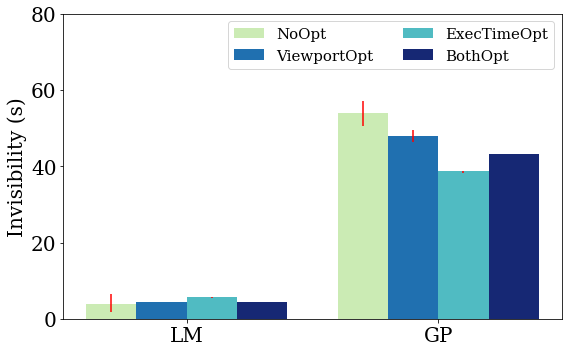

In [316]:
iv_df = massage_data(agg_df, iv_str)
pdf_path = f'{notebook_home}/{opt_str}_regular_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

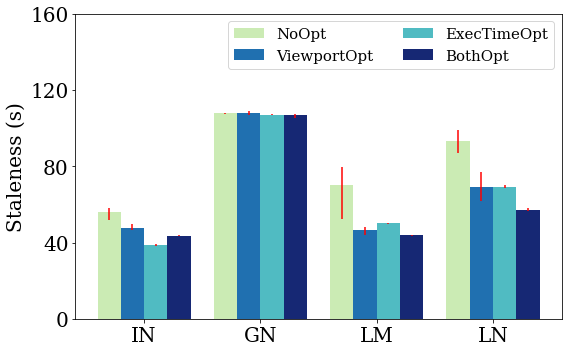

In [317]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_regular_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

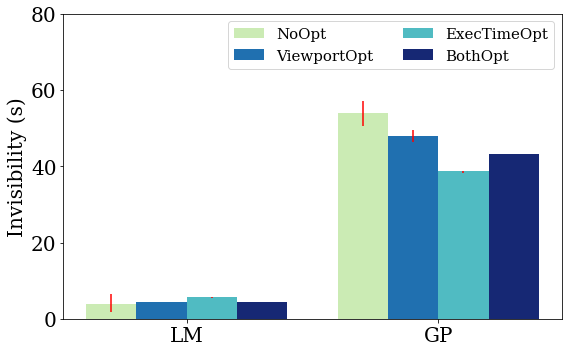

In [318]:
result_home = os.path.join(experiment_home, opt_str, "see_change")
raw_df = read_raw_data_for_optimizations(result_home)
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
pdf_path = f'{notebook_home}/{opt_str}_see_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

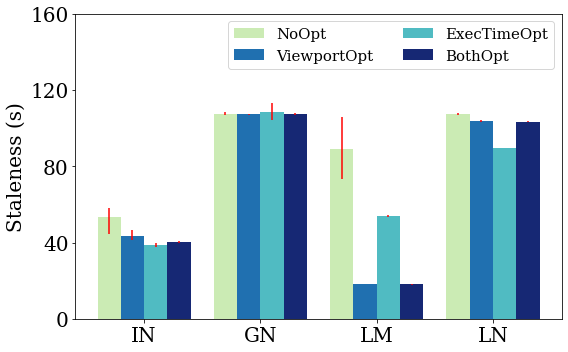

In [319]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_see_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)